In [1]:
import rosbag
import numpy as np
from std_msgs.msg import Int32, String
import matplotlib.pyplot as plt

import rosbag_pandas
import yaml

import warnings
import re
import subprocess
import types

import pandas as pd
import numpy as np

import rospy

%matplotlib notebook

In [54]:
#hard coded function of if statements to get out data we want from bag file
def bag2var(bag, topic):
    
    #create all potential empty lists
    #for tf
    translations_tf_j1 = []
    rotations_tf_j1 = []
    times_tf_j1 = []
    
    translations_tf_j2 = []
    rotations_tf_j2 = []
    times_tf_j2 = []
    
    translations_tf_j3 = []
    rotations_tf_j3 = []
    times_tf_j3 = []
    
    
    #vicon
    positions_vicon = []
    orientations_vicon = []
    times_vicon = []
    
    #robot joint_states
    positions_joints = []
    torques_joints = []
    times_joints = []
    
    #trajectory timing flag
    status_traj = []
    status_times_traj = []
    
    #self defined cycle flag
    cycle_bools = []   
    cycle_times = []
    
    #iterate through, and fill vars based on topic name passed
    for topic, msg, t, in bag.read_messages(topics = [topic]):
        if '/tf' in topic:
            #/tf
            pos = np.array([msg.transforms[0].transform.translation.x, msg.transforms[0].transform.translation.y,
                           msg.transforms[0].transform.translation.z])
            rot = np.array([msg.transforms[0].transform.rotation.w, msg.transforms[0].transform.rotation.x,
                           msg.transforms[0].transform.rotation.y, msg.transforms[0].transform.rotation.z])
            time = msg.transforms[0].header.stamp.to_sec()
            
            frame_id = msg.transforms[0].child_frame_id
            
            if 'j1_dim/base_link' in frame_id:            
                translations_tf_j1.append(pos)
                rotations_tf_j1.append(rot)
                times_tf_j1.append(time)
                
                            
            if 'j2_dim/base_link' in frame_id:            
                translations_tf_j2.append(pos)
                rotations_tf_j2.append(rot)
                times_tf_j2.append(time)
                
                            
            if 'j3_dim/base_link' in frame_id:            
                translations_tf_j3.append(pos)
                rotations_tf_j3.append(rot)
                times_tf_j3.append(time)
            
                           
        if '/vicon/' in topic:
            #/vicon
            pos = np.array([msg.position.x, msg.position.y, msg.position.z])
            rot = np.array([msg.orientation.w, msg.orientation.x, msg.orientation.y, 
                            msg.orientation.z])
            time = msg.header.stamp.to_sec()
            
            positions_vicon.append(pos)
            orientations_vicon.append(rot)
            times_vicon.append(time)
                           
        if '/robot/joint_states' in topic:
            #/joint_states
            if len(msg.name) > 2:  #heuristic to know that we're not getting fingers
                pos = np.array([msg.position])
                torq = np.array([msg.effort])
                time = msg.header.stamp.to_sec()

                positions_joints.append(pos)
                torques_joints.append(torq)
                times_joints.append(time)
                           
        if '/follow_joint_trajectory/status' in topic:
            #/status
            if len(msg.status_list) == 0:
                status_traj.append(0)
            else:
                status = msg.status_list[0].status
                status_traj.append(status)
            status_times_traj.append(msg.header.stamp.to_sec())
                           
        if '/board_pose/cycle_on' in topic:
            #/cycle_on bool
            cycle_bools.append(msg.data)
            
        if '/board_pose/cycle_time' in topic:
            #/cycle_time
            cycle_times.append(msg.data.to_sec())
            
    if '/tf' in topic:
        print "Returning translations, rotations, and timestamps for j1_base_link"
        return (translations_tf_j1, translations_tf_j2, translations_tf_j3, 
                rotations_tf_j1, rotations_tf_j2, rotations_tf_j3,
                times_tf_j1, times_tf_j2, times_tf_j3)
    if '/vicon/' in topic:
        #/vicon
        print "Returning positions, orientations, and timestamps for specified vicon rigid body"
        return positions_vicon, orientations_vicon, times_vicon
    if '/robot/joint_states' in topic:
        #/joint_states
        print "Returning positions and torques of all joints, indexed in order (see Baxter Wiki)"
        return positions_joints, torques_joints, times_joints
    if '/follow_joint_trajectory/status' in topic:
        #/status
        print "Returning trajectory status list with timestamps"
        return status_traj, status_times_traj
    if '/board_pose/cycle_on' in topic:
        #/cycle_on bool
        print "Returning cycle on/off flags"
        return cycle_bools
    if '/board_pose/cycle_time' in topic:
        #/cycle_time
        print "Returning cycle on/off times"
        return cycle_times

#get all data we're currently interested in out     
def allvars(bag):
    global j1_pos, j1_rot, j1_time
    global j2_pos, j2_rot, j2_time
    global j3_pos, j3_rot, j3_time
    global joint_angles, joint_torques, joint_times
    global traj_status, traj_time
    global cycle_on, cycle_time
    global tf1_trans, tf1_rot, tf1_time
    global tf2_trans, tf2_rot, tf2_time
    global tf3_trans, tf3_rot, tf3_time    
    
    print 'getting vicon data...'
    j1_pos, j1_rot, j1_time = bag2var(bag, '/vicon/j1_dim')
    j2_pos, j2_rot, j2_time = bag2var(bag, '/vicon/j2_dim')
    j3_pos, j3_rot, j3_time = bag2var(bag, '/vicon/j3_dim')
    
    print 'getting joint data...'
    joint_angles, joint_torques, joint_times = bag2var(bag, '/robot/joint_states')
    joint_angles = list(np.array(joint_angles).squeeze())
    joint_torqes = list(np.array(joint_torques).squeeze())
    
    print 'getting tf data...'
    tf1_trans, tf2_trans, tf3trans, tf1_rot, tf2_rot, tf3_rot, tf1_time, tf2_time, tf3_time = bag2var(bag, '/tf')
    
    print 'getting trajectory and cycle data...'
    traj_status, traj_time = bag2var(bag, '/robot/limb/right/follow_joint_trajectory/status')
    cycle_time = bag2var(bag, '/board_pose/cycle_time')

In [164]:
#load bag into memory as Bag object
bag = rosbag.Bag('/media/anthony/My Passport/Baxter_Bagfiles/one_joint_two_bag.bag')

In [165]:
#use yaml to make dictionary of info
info_dict = yaml.load(bag._get_yaml_info())

#index through to make a list of topic names
topic_list = []
for i in range(len(info_dict['topics'])):
    topic_list.append(info_dict['topics'][i]['topic'])

print "Topics in Bagfile:   "
print topic_list

Topics in Bagfile:   
['/board_pose/cycle_on', '/board_pose/cycle_time', '/robot/joint_states', '/robot/limb/right/follow_joint_trajectory/status', '/tf', '/vicon/j1_dim', '/vicon/j2_dim', '/vicon/j3_dim']


In [166]:
#run allvars(bag) to get all global variables for plotting and analysis, or get individual variables

allvars(bag)

# traj_status, traj_time = bag2var(bag, '/robot/limb/right/follow_joint_trajectory/status')
# cycle_time = bag2var(bag, '/board_pose/cycle_time')

# joint_angles, joint_torques, joint_times = bag2var(bag, '/robot/joint_states')
# joint_angles = list(np.array(joint_angles).squeeze())
# joint_torques = list(np.array(joint_torques).squeeze())

# j1_pos, j1_rot, j1_time = bag2var(bag, '/vicon/j1_dim')
# j2_pos, j2_rot, j2_time = bag2var(bag, '/vicon/j2_dim')
# j3_pos, j3_rot, j3_time = bag2var(bag, '/vicon/j3_dim')

# tf_trans, tf_rot, tf_time = bag2var(bag, '/tf')

getting vicon data...
Returning positions, orientations, and timestamps for specified vicon rigid body
Returning positions, orientations, and timestamps for specified vicon rigid body
Returning positions, orientations, and timestamps for specified vicon rigid body
getting joint data...
Returning positions and torques of all joints, indexed in order (see Baxter Wiki)
getting tf data...
Returning translations, rotations, and timestamps for j1_base_link
getting trajectory and cycle data...
Returning trajectory status list with timestamps
Returning cycle on/off times


In [167]:
#plan 
#  - index using one of the status times (either traj_time or cycle_time -- try with both)
#  - use some cross correlation/convolution function to align them, choosing one as the master (longest?)
#  - chop off the ends to make them all the same length

def segmentCycles(cycle_t, data_t, data):
    #input - 
    #  cycle_t - time vector of start/stop times of repeated cycles
    #  data_t - vector of timestamps corresponding to data points
    #  data - data vector (should be same length as data_t)
    
    #output - 
    #  data_cycled - list of lists, where first dimension corresponds to cycle number
    #  data_t_cycles - same as above but for timesteps
    
    #function - 
    #  goes get indices of data_t which are closest to those in cycle_t, and then splits up data accordingly
    
    #make all numpy arrays
    cycle_t = np.array(cycle_t)
    data_t = np.array(data_t)
    data = np.array(data)
    
    #index to the 0 at start of times
    cycle_t -= cycle_t[0].copy()
    data_t -= data_t[0].copy()
    
    #lowpass filter the data TODO
    
    #make repeated matrix to perform column wise subtraction and get errors to minimize
    rep_data_t = np.repeat(data_t[:, np.newaxis], cycle_t.shape[0], axis=1)
    delta_t = rep_data_t - cycle_t
    error_t = delta_t * delta_t
    idx_t = np.argmin(error_t, axis=0)
    
    print "Best index matches based on time stamps:"
    print idx_t
    
    #use idx_t to go through data and separate based on cycles
    data_cycled = []
    data_t_cycled = []
    if len(idx_t) % 2 == 0:
        for i in range(1, len(idx_t)/2):
            data_cycled.append(data[idx_t[i*2]:idx_t[i*2+1]])
            data_t_cycled.append(data_t[idx_t[i*2]:idx_t[i*2+1]])
    else:
        for i in range(1, len(idx_t)/2):
            data_cycled.append(data[idx_t[i*2]:idx_t[i*2+1]])
            data_t_cycled.append(data_t[idx_t[i*2]:idx_t[i*2+1]])        
    
    return data_cycled, data_t_cycled

#  should write a function to do this, given the list of ___ times (trajectory or cycle) and the data
#  vectors we want, should return a list of lists which contains the same data split over each cycle

In [168]:
# print j1_time[-1]
# print j2_time[-1]
# print j3_time[-1]
# print tf_time[-1]
# print traj_time[-1]
# print cycle_time[-1]
# print joint_times[-1]

# print j1_time[0]
# print j2_time[0]
# print j3_time[0]
# print tf_time[0]
# print traj_time[0]
# print cycle_time[0]
# print joint_times[0]


test_data, test_time = segmentCycles(cycle_t=cycle_time, data_t=joint_times, data=list(np.array(joint_angles)[:,12]))
print len(test_data), len(test_time)

Best index matches based on time stamps:
[    0  1681  1684  4101  4104  6589  6593  8971  8975 11445 11449 14028
 14033 16596 16599 18994 18998 21440 21443 23896 23899 26261 26265 28720
 28723 31186 31191 34144 34147 36804 36807 39310 39314 41783 41787 44289
 44293 46778 46781 49200]
19 19


In [178]:
def plotSegmentedRaw(data, topic):
    color_idx = np.linspace(0, 1, len(data))
    run_num = np.arange(len(data))
    plt.figure()
    if len(data[0]) == 3:
        for i, col in zip(range(len(data)), color_idx):
            plt.subplot(311)
            plt.plot(data[i][:,0], color = plt.cm.rainbow(col), lw = 1, label = str(run_num[i]))

            plt.subplot(312)
            plt.plot(data[i][:,1], color = plt.cm.rainbow(col), lw = 1, label = str(run_num[i]))

            plt.subplot(313)
            plt.plot(data[i][:,2], color = plt.cm.rainbow(col), lw = 1, label = str(run_num[i]))
    else:        
        for i, col in zip(range(len(data)), color_idx):
            plt.plot(data[i], color = plt.cm.rainbow(col), lw = 1, label = str(run_num[i]))
        
    plt.legend()
    plt.show()

In [179]:
print len(joint_angles[:])
print len(np.array(joint_angles)[:,12])

print len(test_data[0])

51102
51102
2417


<IPython.core.display.Javascript object>


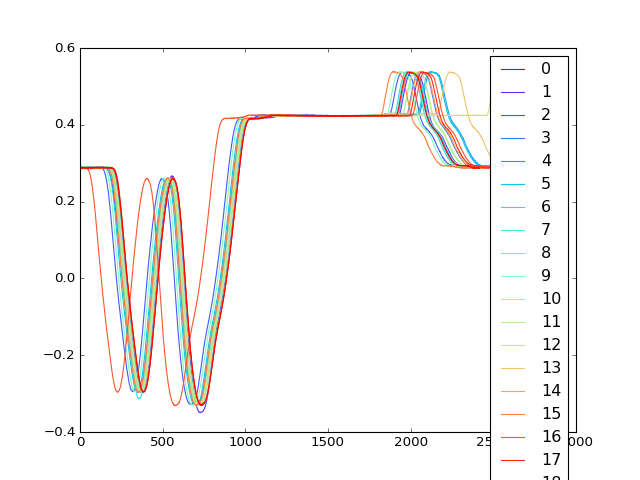

In [180]:
%matplotlib notebook
plotSegmentedRaw(test_data, 'test')
# plt.close()

2953 2417 2485
[0.08272592 0.16545184 0.24839807 ... 0.25071617 0.16721799 0.08371996]
[0.08261577 0.165562   0.24795746 ... 0.24806761 0.16556244 0.08283637]
2431
2483
5369
5437
2938
2954
-522
-470


<IPython.core.display.Javascript object>


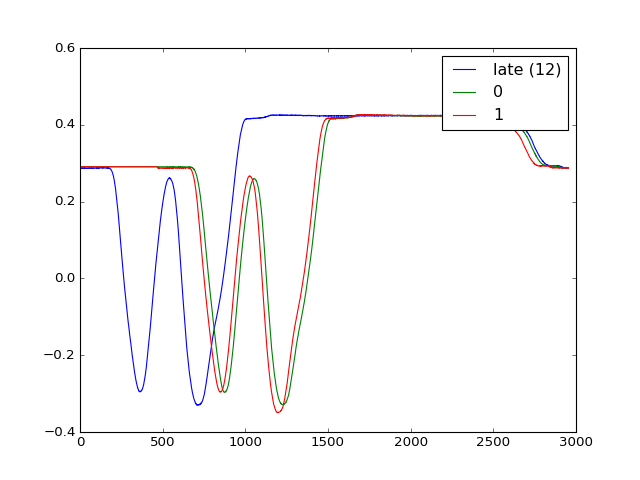

In [264]:
t0 = np.abs(np.correlate(test_data[12], test_data[0], 'full'))
t1 = np.abs(np.correlate(test_data[12], test_data[1], 'full'))

print len(test_data[12]), len(test_data[0]), len(test_data[1])
print t0
print t1
print np.argmax(t0)
print np.argmax(t1)
print len(t0)
print len(t1)
print len(t0) - np.argmax(t0)
print len(t1) - np.argmax(t1)

print np.argmax(t0) - len(test_data[12])
print np.argmax(t1) - len(test_data[12])

# plt.figure(2)
# plt.plot(test_data[12])
# plt.plot(test_data[0][:])
# plt.plot(test_data[1][:])
# plt.legend(['late (12)', '0', '1'])
# plt.show()

plt.figure(2)
plt.plot(test_data[12])
plt.plot(np.insert(test_data[0][:], 0, [test_data[0][0]]*522))
plt.plot(np.insert(test_data[1][:], 0, [test_data[0][0]]*470))
plt.legend(['late (12)', '0', '1'])
plt.show()

In [271]:
#use cross correlation to find time delay between two signals

#get cycle run with earliest deviation
# epsilon = test_data[0][0]*1.5
# ind_first = []

# shifted_data = []

def shiftSignals(data, left_start=True, right_end=False):
    
    epsilon = data[0][0]*1.1
    shifted_data = []
    
    if left_start:
        ind_first = []
        for i in range(len(data)):
            first = np.argwhere(np.abs(data[i] > abs(epsilon)))[0][0]
            ind_first.append(first)
        early_run = np.argmin(ind_first)
        print "most left shifted cycle:"
        print early_run

        for i in range(len(data)):
            if i == early_run:
                shifted_data.append(data[i])
            else:
                ti = np.abs(np.correlate(data[early_run], data[i], 'full'))
                shift = len(data[i]) - np.argmax(ti)
                shifted_data.append(data[i][shift:])
        return shifted_data
    
    elif right_end:
        ind_last = []
        for i in range(len(data)):
            last = np.argwhere(np.abs(data[i] > abs(epsilon)))[-1][0]
            ind_last.append(last)
        last_run = np.argmax(ind_last)
        print "most right shifted cycle:"
        print last_run
        
        for i in range(len(data)):
            if i == last_run:
                shifted_data.append(data[i])
            else:
                ti = np.abs(np.correlate(data[last_run], data[i], 'full'))
                shift = len(data[last_run]) - np.argmax(ti)
                shifted_data.append(np.array(np.insert(data[i], 0, shift*[data[i][0]])))
        return shifted_data
    else:
        print "Please input left shift or right shift"
        return -1

test_shifted = shiftSignals(test_data)

most left shifted cycle:
16


<IPython.core.display.Javascript object>


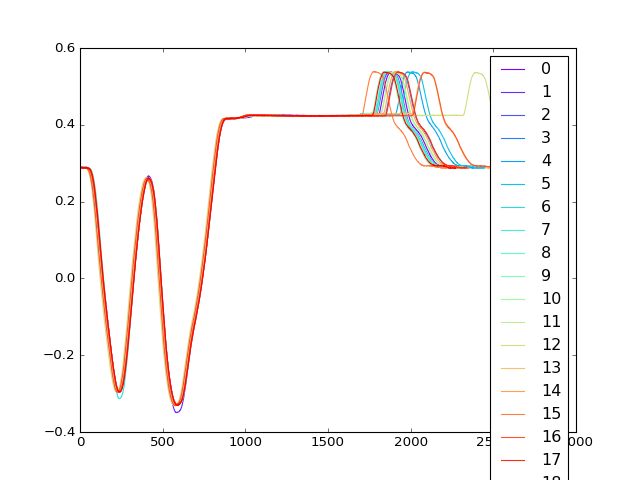

In [272]:
len(test_shifted)
len(test_data)
plotSegmentedRaw(test_shifted, 'test')
# plt.close()

In [253]:
# df = rosbag_pandas.bag_to_dataframe('one_joint_one_bag.bag')

# for c in df.columns:
#     print c, df[c].min(), df[c].max()
len(test_data[0])
test_concat = np.insert(test_data[0], 0, [test_data[0][0]]*5)
len(test_concat)
print test_concat
print len(test_data[0])
print len(test_concat)
print test_concat[:10]

[0.29068936 0.29068936 0.29068936 ... 0.28877188 0.28800489 0.28800489]
2417
2422
[0.29068936 0.29068936 0.29068936 0.29068936 0.29068936 0.29068936
 0.29030586 0.29030586 0.29030586 0.29030586]


In [246]:
# print df.columns
# print rosbag_pandas.get_bag_info('one_joint_one_bag.bag')
# print bag.read_messages(topics = '/tf')
num_msgs = 500
test_list = []
for topic, msg, t in bag.read_messages(topics = ['/tf']):
    if num_msgs < 1:
        break
    num_msgs -= 1
    print msg

transforms: 
  - 
    header: 
      seq: 69905
      stamp: 
        secs: 1519614480
        nsecs: 351445913
      frame_id: "/vicon"
    child_frame_id: "j1_dim/base_link"
    transform: 
      translation: 
        x: 0.429810395284
        y: 0.954886991244
        z: 1.31041623458
      rotation: 
        x: -0.412201485853
        y: 0.733495108153
        z: -0.471038218203
        w: 0.264948784426
transforms: 
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614480
        nsecs: 860592672
      frame_id: "base"
    child_frame_id: "collision_head_link_1"
    transform: 
      translation: 
        x: 0.11
        y: 0.0
        z: 0.75
      rotation: 
        x: 0.0
        y: 0.0
        z: 0.0
        w: 1.0
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614480
        nsecs: 860592672
      frame_id: "base"
    child_frame_id: "collision_head_link_2"
    transform: 
      translation: 
        x: 0.11
        y: 0.0
        z: 0.75
      ro

transforms: 
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614480
        nsecs: 865566494
      frame_id: "reference/base"
    child_frame_id: "reference/collision_head_link_1"
    transform: 
      translation: 
        x: 0.11
        y: 0.0
        z: 0.75
      rotation: 
        x: 0.0
        y: 0.0
        z: 0.0
        w: 1.0
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614480
        nsecs: 865566494
      frame_id: "reference/base"
    child_frame_id: "reference/collision_head_link_2"
    transform: 
      translation: 
        x: 0.11
        y: 0.0
        z: 0.75
      rotation: 
        x: 0.0
        y: 0.0
        z: 0.0
        w: 1.0
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614480
        nsecs: 865566494
      frame_id: "reference/screen"
    child_frame_id: "reference/display"
    transform: 
      translation: 
        x: 0.0
        y: -0.016
        z: 0.0
      rotation: 
        x: 0.0
        y: 0.0
  

transforms: 
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614480
        nsecs: 960117343
      frame_id: "base"
    child_frame_id: "collision_head_link_1"
    transform: 
      translation: 
        x: 0.11
        y: 0.0
        z: 0.75
      rotation: 
        x: 0.0
        y: 0.0
        z: 0.0
        w: 1.0
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614480
        nsecs: 960117343
      frame_id: "base"
    child_frame_id: "collision_head_link_2"
    transform: 
      translation: 
        x: 0.11
        y: 0.0
        z: 0.75
      rotation: 
        x: 0.0
        y: 0.0
        z: 0.0
        w: 1.0
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614480
        nsecs: 960117343
      frame_id: "screen"
    child_frame_id: "display"
    transform: 
      translation: 
        x: 0.0
        y: -0.016
        z: 0.0
      rotation: 
        x: 0.0
        y: 0.0
        z: 0.0
        w: 1.0
  - 
    header: 
      seq: 0
 

transforms: 
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614481
        nsecs:  80846561
      frame_id: "base"
    child_frame_id: "collision_head_link_1"
    transform: 
      translation: 
        x: 0.11
        y: 0.0
        z: 0.75
      rotation: 
        x: 0.0
        y: 0.0
        z: 0.0
        w: 1.0
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614481
        nsecs:  80846561
      frame_id: "base"
    child_frame_id: "collision_head_link_2"
    transform: 
      translation: 
        x: 0.11
        y: 0.0
        z: 0.75
      rotation: 
        x: 0.0
        y: 0.0
        z: 0.0
        w: 1.0
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614481
        nsecs:  80846561
      frame_id: "screen"
    child_frame_id: "display"
    transform: 
      translation: 
        x: 0.0
        y: -0.016
        z: 0.0
      rotation: 
        x: 0.0
        y: 0.0
        z: 0.0
        w: 1.0
  - 
    header: 
      seq: 0
 

transforms: 
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614481
        nsecs: 200519424
      frame_id: "base"
    child_frame_id: "collision_head_link_1"
    transform: 
      translation: 
        x: 0.11
        y: 0.0
        z: 0.75
      rotation: 
        x: 0.0
        y: 0.0
        z: 0.0
        w: 1.0
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614481
        nsecs: 200519424
      frame_id: "base"
    child_frame_id: "collision_head_link_2"
    transform: 
      translation: 
        x: 0.11
        y: 0.0
        z: 0.75
      rotation: 
        x: 0.0
        y: 0.0
        z: 0.0
        w: 1.0
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614481
        nsecs: 200519424
      frame_id: "screen"
    child_frame_id: "display"
    transform: 
      translation: 
        x: 0.0
        y: -0.016
        z: 0.0
      rotation: 
        x: 0.0
        y: 0.0
        z: 0.0
        w: 1.0
  - 
    header: 
      seq: 0
 

transforms: 
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614481
        nsecs: 284927602
      frame_id: "reference/base"
    child_frame_id: "reference/collision_head_link_1"
    transform: 
      translation: 
        x: 0.11
        y: 0.0
        z: 0.75
      rotation: 
        x: 0.0
        y: 0.0
        z: 0.0
        w: 1.0
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614481
        nsecs: 284927602
      frame_id: "reference/base"
    child_frame_id: "reference/collision_head_link_2"
    transform: 
      translation: 
        x: 0.11
        y: 0.0
        z: 0.75
      rotation: 
        x: 0.0
        y: 0.0
        z: 0.0
        w: 1.0
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614481
        nsecs: 284927602
      frame_id: "reference/screen"
    child_frame_id: "reference/display"
    transform: 
      translation: 
        x: 0.0
        y: -0.016
        z: 0.0
      rotation: 
        x: 0.0
        y: 0.0
  

transforms: 
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614480
        nsecs: 901065057
      frame_id: "reference/torso"
    child_frame_id: "reference/head"
    transform: 
      translation: 
        x: 0.06
        y: 0.0
        z: 0.686
      rotation: 
        x: 0.0
        y: 0.0
        z: -0.156396587552
        w: 0.987694339055
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614480
        nsecs: 901065057
      frame_id: "reference/left_lower_shoulder"
    child_frame_id: "reference/left_upper_elbow"
    transform: 
      translation: 
        x: 0.102
        y: 0.0
        z: 0.0
      rotation: 
        x: 0.494747829676
        y: 0.505197570292
        z: 0.494747829676
        w: 0.505197570297
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614480
        nsecs: 901065057
      frame_id: "reference/left_upper_elbow"
    child_frame_id: "reference/left_lower_elbow"
    transform: 
      translation: 
        x: 0.069

transforms: 
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614481
        nsecs: 485583839
      frame_id: "reference/base"
    child_frame_id: "reference/collision_head_link_1"
    transform: 
      translation: 
        x: 0.11
        y: 0.0
        z: 0.75
      rotation: 
        x: 0.0
        y: 0.0
        z: 0.0
        w: 1.0
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614481
        nsecs: 485583839
      frame_id: "reference/base"
    child_frame_id: "reference/collision_head_link_2"
    transform: 
      translation: 
        x: 0.11
        y: 0.0
        z: 0.75
      rotation: 
        x: 0.0
        y: 0.0
        z: 0.0
        w: 1.0
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614481
        nsecs: 485583839
      frame_id: "reference/screen"
    child_frame_id: "reference/display"
    transform: 
      translation: 
        x: 0.0
        y: -0.016
        z: 0.0
      rotation: 
        x: 0.0
        y: 0.0
  

transforms: 
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614481
        nsecs:  71061095
      frame_id: "reference/torso"
    child_frame_id: "reference/head"
    transform: 
      translation: 
        x: 0.06
        y: 0.0
        z: 0.686
      rotation: 
        x: 0.0
        y: 0.0
        z: -0.156396587552
        w: 0.987694339055
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614481
        nsecs:  71061095
      frame_id: "reference/left_lower_shoulder"
    child_frame_id: "reference/left_upper_elbow"
    transform: 
      translation: 
        x: 0.102
        y: 0.0
        z: 0.0
      rotation: 
        x: 0.494747829676
        y: 0.505197570292
        z: 0.494747829676
        w: 0.505197570297
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614481
        nsecs:  71061095
      frame_id: "reference/left_upper_elbow"
    child_frame_id: "reference/left_lower_elbow"
    transform: 
      translation: 
        x: 0.069

transforms: 
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614481
        nsecs: 640161264
      frame_id: "base"
    child_frame_id: "collision_head_link_1"
    transform: 
      translation: 
        x: 0.11
        y: 0.0
        z: 0.75
      rotation: 
        x: 0.0
        y: 0.0
        z: 0.0
        w: 1.0
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614481
        nsecs: 640161264
      frame_id: "base"
    child_frame_id: "collision_head_link_2"
    transform: 
      translation: 
        x: 0.11
        y: 0.0
        z: 0.75
      rotation: 
        x: 0.0
        y: 0.0
        z: 0.0
        w: 1.0
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614481
        nsecs: 640161264
      frame_id: "screen"
    child_frame_id: "display"
    transform: 
      translation: 
        x: 0.0
        y: -0.016
        z: 0.0
      rotation: 
        x: 0.0
        y: 0.0
        z: 0.0
        w: 1.0
  - 
    header: 
      seq: 0
 

transforms: 
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614481
        nsecs: 744803016
      frame_id: "reference/base"
    child_frame_id: "reference/collision_head_link_1"
    transform: 
      translation: 
        x: 0.11
        y: 0.0
        z: 0.75
      rotation: 
        x: 0.0
        y: 0.0
        z: 0.0
        w: 1.0
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614481
        nsecs: 744803016
      frame_id: "reference/base"
    child_frame_id: "reference/collision_head_link_2"
    transform: 
      translation: 
        x: 0.11
        y: 0.0
        z: 0.75
      rotation: 
        x: 0.0
        y: 0.0
        z: 0.0
        w: 1.0
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614481
        nsecs: 744803016
      frame_id: "reference/screen"
    child_frame_id: "reference/display"
    transform: 
      translation: 
        x: 0.0
        y: -0.016
        z: 0.0
      rotation: 
        x: 0.0
        y: 0.0
  

transforms: 
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614481
        nsecs: 840140227
      frame_id: "base"
    child_frame_id: "collision_head_link_1"
    transform: 
      translation: 
        x: 0.11
        y: 0.0
        z: 0.75
      rotation: 
        x: 0.0
        y: 0.0
        z: 0.0
        w: 1.0
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614481
        nsecs: 840140227
      frame_id: "base"
    child_frame_id: "collision_head_link_2"
    transform: 
      translation: 
        x: 0.11
        y: 0.0
        z: 0.75
      rotation: 
        x: 0.0
        y: 0.0
        z: 0.0
        w: 1.0
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614481
        nsecs: 840140227
      frame_id: "screen"
    child_frame_id: "display"
    transform: 
      translation: 
        x: 0.0
        y: -0.016
        z: 0.0
      rotation: 
        x: 0.0
        y: 0.0
        z: 0.0
        w: 1.0
  - 
    header: 
      seq: 0
 

transforms: 
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614481
        nsecs: 944641081
      frame_id: "reference/base"
    child_frame_id: "reference/collision_head_link_1"
    transform: 
      translation: 
        x: 0.11
        y: 0.0
        z: 0.75
      rotation: 
        x: 0.0
        y: 0.0
        z: 0.0
        w: 1.0
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614481
        nsecs: 944641081
      frame_id: "reference/base"
    child_frame_id: "reference/collision_head_link_2"
    transform: 
      translation: 
        x: 0.11
        y: 0.0
        z: 0.75
      rotation: 
        x: 0.0
        y: 0.0
        z: 0.0
        w: 1.0
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614481
        nsecs: 944641081
      frame_id: "reference/screen"
    child_frame_id: "reference/display"
    transform: 
      translation: 
        x: 0.0
        y: -0.016
        z: 0.0
      rotation: 
        x: 0.0
        y: 0.0
  

transforms: 
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614482
        nsecs:  65125628
      frame_id: "reference/base"
    child_frame_id: "reference/collision_head_link_1"
    transform: 
      translation: 
        x: 0.11
        y: 0.0
        z: 0.75
      rotation: 
        x: 0.0
        y: 0.0
        z: 0.0
        w: 1.0
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614482
        nsecs:  65125628
      frame_id: "reference/base"
    child_frame_id: "reference/collision_head_link_2"
    transform: 
      translation: 
        x: 0.11
        y: 0.0
        z: 0.75
      rotation: 
        x: 0.0
        y: 0.0
        z: 0.0
        w: 1.0
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614482
        nsecs:  65125628
      frame_id: "reference/screen"
    child_frame_id: "reference/display"
    transform: 
      translation: 
        x: 0.0
        y: -0.016
        z: 0.0
      rotation: 
        x: 0.0
        y: 0.0
  

transforms: 
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614481
        nsecs: 651059868
      frame_id: "reference/torso"
    child_frame_id: "reference/head"
    transform: 
      translation: 
        x: 0.06
        y: 0.0
        z: 0.686
      rotation: 
        x: 0.0
        y: 0.0
        z: -0.156396587552
        w: 0.987694339055
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614481
        nsecs: 651059868
      frame_id: "reference/left_lower_shoulder"
    child_frame_id: "reference/left_upper_elbow"
    transform: 
      translation: 
        x: 0.102
        y: 0.0
        z: 0.0
      rotation: 
        x: 0.494747829676
        y: 0.505197570292
        z: 0.494747829676
        w: 0.505197570297
  - 
    header: 
      seq: 0
      stamp: 
        secs: 1519614481
        nsecs: 651059868
      frame_id: "reference/left_upper_elbow"
    child_frame_id: "reference/left_lower_elbow"
    transform: 
      translation: 
        x: 0.069

In [7]:
num_msgs = 500
test_list = []
for topic, msg, t in bag.read_messages(topics = ['/board_pose/cycle_time']):
    if num_msgs < 1:
        break
    num_msgs -= 1
    print msg

data: 
  secs: 1519613963
  nsecs: 350081920
data: 
  secs: 1519613979
  nsecs: 376889944
data: 
  secs: 1519613979
  nsecs: 418895006
data: 
  secs: 1519614005
  nsecs: 899580955
data: 
  secs: 1519614005
  nsecs: 931762933
data: 
  secs: 1519614031
  nsecs:  20085096
data: 
  secs: 1519614031
  nsecs:  58675050
data: 
  secs: 1519614056
  nsecs: 902893066
data: 
  secs: 1519614056
  nsecs: 941163063
data: 
  secs: 1519614082
  nsecs: 635942935
data: 
  secs: 1519614082
  nsecs: 672346115
data: 
  secs: 1519614108
  nsecs: 153728961
data: 
  secs: 1519614108
  nsecs: 189671039
data: 
  secs: 1519614133
  nsecs: 868149995
data: 
  secs: 1519614133
  nsecs: 893973112
data: 
  secs: 1519614159
  nsecs: 650764942
data: 
  secs: 1519614159
  nsecs: 685448884
data: 
  secs: 1519614184
  nsecs: 977061033
data: 
  secs: 1519614185
  nsecs:   9675979
data: 
  secs: 1519614212
  nsecs: 327310085
data: 
  secs: 1519614212
  nsecs: 351809024
data: 
  secs: 1519614238
  nsecs:  49293041
data: 
  s

In [ ]:
class Baxter_Data_Analysis(topics):
    def __init__(self):
        self.topics = topics
        self.date
        self.
    
    self.known_topics = ['/board_pose/cycle_on', '/board_pose/cycle_time', '/robot/joint_states',
                         '/robot/limb/right/follow_joint_trajectory/status',
                         '/tf', '/vicon/j1_dim', '/vicon/j2_dim', '/vicon/j3_dim']
